In [ ]:
!pip install deel-lip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import collections  as mc
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, ReLU, MaxPool2D, Lambda, Dense, AveragePooling2D
from deel.lip.model import Sequential
from deel.lip.layers import SpectralConv2D, SpectralDense, FrobeniusDense, LipschitzLayer, ScaledGlobalAveragePooling2D
from deel.lip.initializers import BjorckInitializer
from deel.lip.activations import MaxMin, GroupSort, FullSort
import tensorflow as tf

In [ ]:
!pip3 install ColabTurtle

  Created wheel for ColabTurtle: filename=ColabTurtle-2.1.0-cp37-none-any.whl size=7661 sha256=b7cba4fe64b8f4f193dc3b6905ad909f0fee2b9b6d1932ff0dbbca108819f456
  Stored in directory: /root/.cache/pip/wheels/df/e9/3f/df3fccd8971c5473dc0c6450984cd057de8c9a1271069ebf18
Successfully built ColabTurtle


In [ ]:
def get_squared_distance(query, points, vecs):
    """
    Args:
        query: array of shape (N,2) of coordinates of points
        point: array of points of departure (P,2)
        vecs: array of vectors (P,2)

    (points,vecs) describes the set of segments
    query the set of points for which we want to know |f(x)|

    Return:
        dists: distance to the frontiere dists
        signs: up (+1) or down (-1) side
    """
    x, p, u = query, points, vecs
    l = u[:,0]**2 + u[:,1]**2
    delta = x[:,np.newaxis,:] - p[np.newaxis,:,:]
    bt = np.einsum('isx,sx->is', delta, u)
    bt = bt / (l[np.newaxis,:] + 1e-6)
    t = np.clip(bt, 0., 1.)
    y = p + t[:,:,np.newaxis]*u[np.newaxis,:,:]
    l = y - x[:,np.newaxis,:]
    l = l[:,:,0]**2 + l[:,:,1]**2
    dists = np.min(l, axis=1)
    delta = p[np.newaxis,:,:] - x[:,np.newaxis,:]
    su = np.sign(u[:,0])[np.newaxis,:]
    cx = u[np.newaxis,:,0]*delta[:,:,1]
    cy = u[np.newaxis,:,1]*delta[:,:,0]
    star_t = su*(cx - cy)
    star_t_prime = -su*delta[:,:,0]
    ua = np.abs(u[:,0])[np.newaxis,:]
    intersect = (star_t >= 0) & (star_t_prime >= 0) & (star_t_prime <= ua)
    count = np.sum(intersect, axis=1, dtype=np.int64)
    is_even = np.mod(count, 2) == 0
    signs = np.ones(shape=len(query))
    signs[~is_even] = -1.
    return dists, signs

def generate_support(inf_x, sup_x, inf_y, sup_y, inflexions, scale):
    mid_x = (sup_x + inf_x)/2.
    mid_y = (sup_y + inf_y)/2.
    scale = (sup_y - inf_y)*scale
    x = np.sort(np.random.uniform(inf_x, sup_x, size=(inflexions-2)))
    y = np.random.normal(mid_y, scale, size=(inflexions-2))
    xy = np.concatenate((x[:,np.newaxis],y[:,np.newaxis]),axis=1)
    xy = np.concatenate(([[inf_x, mid_y]], xy, [[sup_x, mid_y]]), axis=0)
    xy = xy - np.array([[mid_x, mid_y]])
    points = xy[:-1]
    vecs = xy[1:] - xy[:-1]
    return points, vecs, xy

import math
class MyTurtle:
  def __init__(self):
    self.x = 0
    self.y = 0
    self.degree = 0
  def pos(self):
    return [self.x, self.y]
  def goto(self, x, y):
    self.x = x
    self.y = y
  def left(self, angle):
    self.right(-angle)
  def right(self, degrees):
    self.degree = (self.degree + degrees + 360) % 360
  def forward(self, units):
    alpha = math.radians(self.degree)
    ending_point = (self.x + units * math.cos(alpha), self.y + units * math.sin(alpha))
    self.x = ending_point[0]
    self.y = ending_point[1]


def draw_koch(inf_x, sup_x, inf_y, sup_y, size):
    turtle = MyTurtle()
    # import turtle as turtle
    # turtle.speed(13)
    # turtle.up()
    dx = (sup_x - inf_x) * size
    dy = (sup_y - inf_y) * size
    start_x = -dx*0.5
    start_y = -dy*(3**0.5)/6
    turtle.goto(start_x, start_y)
    # turtle.down()
    def recur(a, order):
        if order > 0:
            xy_local = []
            for t in [60, -120, 60, 0]:
                xy_recur = recur(a/3, order-1)
                xy_local += xy_recur
                turtle.left(t)
            return xy_local
        else:
            turtle.forward(a)
            return [turtle.pos()]
    a_init = (sup_x - inf_x)*size
    order_max = 4
    xy = [[start_x, start_y]]
    for _ in range(3):
        xy += recur(a_init, order_max)
        turtle.right(120)
    xy = np.array(xy)
    points = xy[:-1]
    vecs = xy[1:] - xy[:-1]
    return points, vecs, xy

def koch_generator(points, vecs, inf_x, sup_x, inf_y, sup_y, batch_size):
    while True:
        query = np.random.uniform([inf_x, inf_y], [sup_x, sup_y], size=(batch_size, 2))
        dists, signs = get_squared_distance(query, points, vecs)
        dists = (dists**0.5)
        dists = dists * signs
        yield query, dists

def grid_koch_generator(points, vecs, inf_x, sup_x, inf_y, sup_y, resolution):
    range_y = np.linspace(inf_y, sup_y, resolution)
    for y in range_y:
        query_x = np.linspace(inf_x, sup_x, resolution)[:,np.newaxis]
        query_y = np.full(shape=(resolution,1), fill_value=y)
        query = np.concatenate((query_x, query_y), axis=1)
        dists, signs = get_squared_distance(query, points, vecs)
        dists = (dists**0.5)
        dists = dists * signs
        yield query, dists


def train(model, generator, epochs):
    model.compile(optimizer=Adam(),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['mse','mae'])
    model.fit(generator, steps_per_epoch=600, epochs=epochs)
    #model.fit(generator, steps_per_epoch=20, epochs=epochs)
    return model

In [ ]:
resolution = 200
test_resolution = 1000
inf_x, sup_x = -200, 200
inf_y, sup_y = -200, 200
nx, ny = (resolution, resolution)
x = np.linspace(inf_x, sup_x, nx)
y = np.linspace(inf_y, sup_y, ny)
xx, yy = np.meshgrid(x, y)
flat_xx, flat_yy = xx.ravel()[:,np.newaxis],yy.ravel()[:,np.newaxis]
query = np.concatenate([flat_xx, flat_yy], axis=1)
points_big, vecs_big, xy_big = draw_koch(inf_x, sup_x, inf_y, sup_y, size=(87/100))
points_small, vecs_small, xy_small = draw_koch(inf_x, sup_x, inf_y, sup_y, size=(45/100))
points = np.concatenate((points_big, points_small), axis=0)
vecs = np.concatenate((vecs_big, vecs_small), axis=0)
generator = koch_generator(points, vecs, inf_x, sup_x, inf_y, sup_y, batch_size=256)
epochs = 50
training = True
if training:
  create = False
  if create:
    model = Sequential([
      Input(shape=(2)),
      SpectralDense(128, kernel_initializer=BjorckInitializer(15, 50)),
      FullSort(),
      SpectralDense(128, kernel_initializer=BjorckInitializer(15, 50)),
      FullSort(),
      SpectralDense(128, kernel_initializer=BjorckInitializer(15, 50)),
      FullSort(),
      SpectralDense(128, kernel_initializer=BjorckInitializer(15, 50)),
      FullSort(),
      SpectralDense(128, kernel_initializer=BjorckInitializer(15, 50)),
      FullSort(),
      SpectralDense(1, activation="linear")])
  model = train(model, generator, epochs=epochs)
  model = model.vanilla_export()
  _ = model(generator.__next__()[0].astype(dtype=np.float32))

grid_generator = grid_koch_generator(points, vecs, inf_x, sup_x, inf_y, sup_y, test_resolution)
from tqdm import tqdm
progress = tqdm(total=test_resolution, position=0, leave=True)
init = False
for step, (batch_input, _) in enumerate(grid_generator):
    predicted = model.predict(batch_input)
    fx, fy = batch_input[:,0], batch_input[:,1]
    eps = 0.5
    indices = np.squeeze(np.abs(predicted) < eps)
    if np.sum(indices) != 0:
        if not init:
            init = True
            frontiere_xx = fx[indices]
            frontiere_yy = fy[indices]
            frontiere = predicted[indices]
        else:
            frontiere_xx = np.concatenate((frontiere_xx, fx[indices]), axis=0)
            frontiere_yy = np.concatenate((frontiere_yy, fy[indices]), axis=0)
            frontiere = np.concatenate((frontiere, predicted[indices]), axis=0)
    progress.update(1)
progress.close()
dists, signs = get_squared_distance(query, points, vecs)
dists = (dists**0.5)
dists = dists * signs
a = points[:,np.newaxis,:]
b = (points + vecs)[:,np.newaxis,:]
lines = np.concatenate([a, b], axis=1)
dists = dists.reshape(xx.shape)
predicted = model.predict(query, batch_size=256, verbose=1)
predicted = predicted.reshape(xx.shape)
print('')

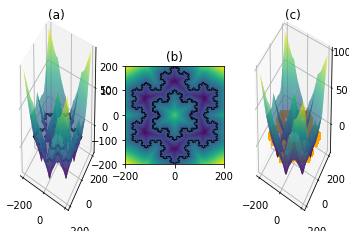

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(131, projection='3d')
ax.set_aspect('auto')
ax.set_title('(a)')
ax.plot(xy_small[:,0], xy_small[:,1], 0., '-', color='black')
ax.plot(xy_big[:,0], xy_big[:,1], 0., '-', color='black')
surf = ax.plot_surface(xx, yy, dists, cmap='viridis', rstride=1, cstride=1, edgecolor='none')

ax = fig.add_subplot(132)
ax.set_aspect('equal')
ax.set_title('(b)')
ax.contourf(xx, yy, dists, levels=150, cmap='viridis')
lc = mc.LineCollection(lines, colors='black', linewidths=1)
ax.add_collection(lc)

ax = fig.add_subplot(133, projection='3d')
ax.set_aspect('auto')
ax.set_title('(c)')
ax.plot(xy_small[:,0], xy_small[:,1], 0., '-', color='black')
ax.plot(xy_big[:,0], xy_big[:,1], 0., '-', color='black')
surf = ax.plot_surface(xx, yy, predicted, cmap='viridis', rstride=1, cstride=1, edgecolor='none')
ax.scatter(np.squeeze(frontiere_xx), np.squeeze(frontiere_yy), np.zeros(shape=frontiere_xx.shape), c='orange', marker=',')

plt.show()

In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(z=dists, x=np.linspace(-200, 200, 200), y=np.linspace(-200, 200, 200)))
fig.add_trace(go.Scatter(x=xy_big[:,0], y=xy_big[:,1],
                    mode='lines', marker_color='green'))
fig.add_trace(go.Scatter(x=xy_small[:,0], y=xy_small[:,1],
                    mode='lines', marker_color='green'))
fig.update_layout(title='Ground Truth', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

fx = np.squeeze(frontiere_xx)
fy = np.squeeze(frontiere_yy)
fz = np.zeros(shape=frontiere_xx.shape)
df = pd.DataFrame(np.array([fx, fy, fz]).T, columns=['x','y','z'])

print(predicted.shape, xx.shape, yy.shape)
fig = go.Figure(data=[go.Surface(z=predicted, x=np.linspace(-200, 200, 200), y=np.linspace(-200, 200, 200))])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig = fig.add_trace(go.Scatter3d(x=fx, y=fy, z=fz, mode='markers', marker={'color':'rgba(0, 256, 0, .8)', 'size':2}))
fig.update_layout(title='Fitted', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

(200, 200) (200, 200) (200, 200)
